In [1]:
from PhaseEstimation import vqe, hamiltonians as ham, qcnn,encoder as enc
from PhaseEstimation import annni_model
from PhaseEstimation import visualization as qplt, general as qmlgen

import numpy as np

In [2]:
myvqe = vqe.load_vqe('./test')

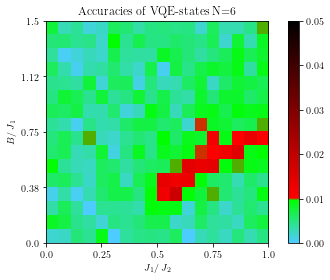

In [3]:
qplt.show_VQE_annni(myvqe)

In [4]:
myenc  = enc.encoder(myvqe, enc.encoder_circuit) 

In [5]:
myenc.train(0.001, 10000, np.array([0]), circuit = False)

Cost: 0.003641098737716675: 100%|██████████| 10000/10000 [00:23<00:00, 430.43it/s]


In [6]:
qplt.show_compression_ANNNI(myenc, [0], plot3d = True)

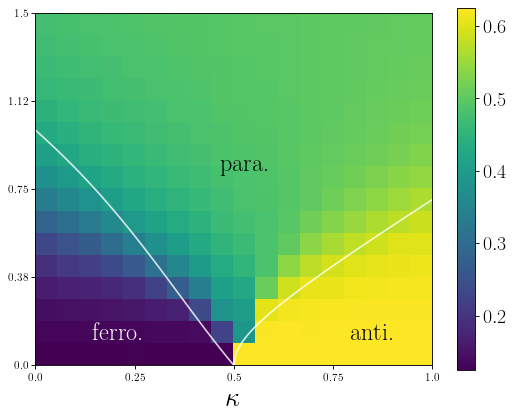

In [7]:
qplt.show_compression_ANNNI(myenc, [0], plot3d = False)

In [8]:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import plotly.graph_objects as go

from PhaseEstimation import general as qmlgen
from PhaseEstimation import vqe

from typing import List, Callable

from matplotlib import rc

rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
rc("font", **{"family": "serif", "serif": ["Computer Modern Roman"]})
rc("text", usetex=True)

def getlines(
    func: Callable, xrange: List[float], side: int, color: str, res: int = 100
):
    """
    Plot function func from xrange[0] to xrange[1]
    This first function assumes your parameter ranges are
    > h     : [ 0, 2]
    > kappa : [ 0,-1]

    """
    xs = np.linspace(xrange[0], xrange[1], res)
    ys = func(xs)
    plt.plot(side * xs - 0.5, side - ys * side / 2 - 0.5, color=color, alpha=0.8)

def getlines_from_vqe(
    vqeclass, func: Callable, xrange: List[float], color: str, res: int = 100
):
    """
    Plot function func from xrange[0] to xrange[1]
    This function uses the VQE class to plot the function 
    according to the vqe ranges of its parameters
    """

    # Get information from vqeclass for plotting
    # (func needs to be resized)
    side_x = vqeclass.Hs.n_kappas
    side_y = vqeclass.Hs.n_hs
    max_x  = vqeclass.Hs.kappa_max

    yrange = [0, vqeclass.Hs.h_max]
    
    xs = np.linspace(xrange[0], xrange[1], res)
    ys = func(xs)

    ys[ys > yrange[1]] = yrange[1]
    
    corrected_xs = (side_x * xs / max_x - 0.5)

    plt.plot(corrected_xs, side_y - ys * side_y / yrange[1] - 0.5, color=color, alpha=0.8)

In [35]:

def show_compression_ANNNI(encclass, trainingpoint=False, label=False, plot3d=False):
    """
    Shows result of compression of the Anomaly Detector
    """

    sidex = encclass.vqe.Hs.n_kappas
    sidey = encclass.vqe.Hs.n_hs
    max_x = encclass.vqe.Hs.kappa_max
    max_y = encclass.vqe.Hs.h_max
    x = np.linspace(-max_x, 0, sidex)
    y = np.linspace(0, max_y, sidey)

    X = jnp.array(encclass.vqe_params0)

    @qml.qnode(encclass.device, interface="jax")
    def encoder_circuit(vqe_params, params):
        encclass._vqe_enc_circuit(vqe_params, params)

        return [qml.expval(qml.PauliZ(int(k))) for k in encclass.wires_trash]

    v_encoder_circuit = jax.vmap(lambda p: encoder_circuit(p, encclass.params))

    exps = (1 - np.sum(v_encoder_circuit(X), axis=1) / 4) / 2

    exps = np.rot90(np.reshape(exps, (sidex, sidey)))

    if plot3d:
        fig = go.Figure(data=[go.Surface(z=exps, x=x, y=y)])
        fig.update_layout(height=500)
        fig.show()
    else:
        plt.figure(figsize=(8, 6), dpi=80)
        plt.imshow(exps)

        # plt.ylabel(r'$h$', fontsize=24)
        plt.xlabel(r"$\kappa$", fontsize=24)

        ticks_x = [-.5 , encclass.vqe.Hs.n_kappas/4 - .5, encclass.vqe.Hs.n_kappas/2 - .5 , 3*encclass.vqe.Hs.n_kappas/4 - .5, encclass.vqe.Hs.n_kappas - .5]
        ticks_y = [-.5 , encclass.vqe.Hs.n_hs/4 - .5, encclass.vqe.Hs.n_hs/2 - .5 , 3*encclass.vqe.Hs.n_hs/4 - .5, encclass.vqe.Hs.n_hs - .5]

        plt.xticks(
            ticks= ticks_x,
            labels=[np.round(k * encclass.vqe.Hs.kappa_max  / 4, 2) for k in range(0, 5)],
        )
        plt.yticks(
            ticks=ticks_y,
            labels=[np.round(k * encclass.vqe.Hs.h_max / 4, 2) for k in range(4, -1, -1)],
        )

        getlines_from_vqe(encclass.vqe, qmlgen.paraanti, [0.5, 1 - 1e-5], "white", res=100)
        getlines_from_vqe(encclass.vqe, qmlgen.paraferro, [1e-5, 0.5], "white", res=100)

        if type(trainingpoint) == int:
            train_x = trainingpoint // sidex
            train_y = sidey - trainingpoint % sidey
            if train_x == 0:
                train_x += 1
                print(train_x)
            if train_y == sidey:
                train_y -= 2 / max_y

            plt.scatter(
                [train_x],
                [train_y],
                marker="+",
                s=300,
                color="orangered",
                label=r"Initial state $\left|\psi\right\rangle$",
            )
            plt.ylim(sidey - 1, 0)
            plt.xlim(0, sidex - 1)

            leg = plt.legend(
                bbox_to_anchor=(1, 1),
                loc="upper right",
                fontsize=16,
                facecolor="white",
                markerscale=0.8,
                framealpha=0.9,
                title=r"AD,     $N = {0}$".format(str(encclass.vqe.Hs.N)),
                title_fontsize=16,
            )
            leg.get_frame().set_boxstyle("Square")

        if label:
            plt.figtext(0.23, 0.79, "(" + label + ")", color="black", fontsize=20)
        plt.text(
            sidex * 0.5,
            sidey * 0.4,
            "para.",
            color="black",
            fontsize=22,
            ha="center",
            va="center",
        )
        plt.text(
            sidex * 0.18,
            sidey * 0.88,
            "ferro.",
            color="white",
            fontsize=22,
            ha="center",
            va="center",
        )
        plt.text(
            sidex * 0.82,
            sidey * 0.88,
            "anti.",
            color="black",
            fontsize=22,
            ha="center",
            va="center",
        )

        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=18)


1


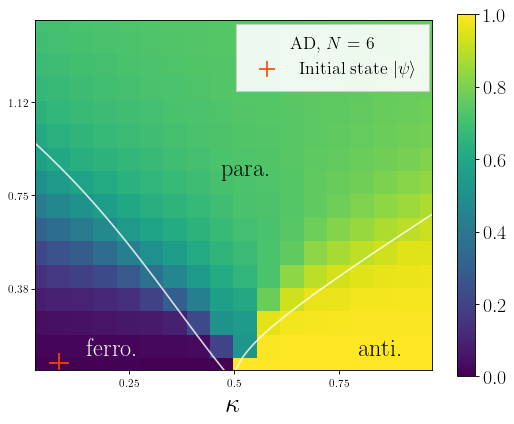

: 

In [36]:
show_compression_ANNNI(myenc, trainingpoint = 0, plot3d = False)